## CMEE MSC Project 2019
### Scale frequency analysis of foraging data above 1Km
---

In [22]:
# import tools #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
plt.style.use("seaborn-white")

# add code path to environment #
import sys
sys.path.insert(1, "../Code/")

# import package for sum of exponential fitting #
import config
from sumexp import *

# functions #
def fit_sumexp(data, lower, upper, resolution, geom=True):
    # fit a sum of exponentials, return model, psi values
    if geom:
        config.FIXED_RATES = np.geomspace(lower, upper, resolution)
    else:
        config.FIXED_RATES = np.linspace(lower, upper, resolution)
    startest = [1/len(config.FIXED_RATES)] * (len(config.FIXED_RATES)-1)
    model = minimize_model(startest, data)
    psi = model.x
    psi = np.append(psi, 1-sum(psi))
    return (model, psi, config.FIXED_RATES)

def single_exp(r, x):
    # get likelihood of single exponential
    return np.sum(np.log(r*np.exp(-r*x)))

def aic_eq(ll, params):
    # Calculates AIC of given likelihood and parameter numbers.
    k = len(params)
    return -2 * ll + 2 * k

def inverse_cdf(data):
    # Produce the inverse CDF of 1-d data provided.
    sorted_data = -np.sort(-data)
    prob = np.arange(0, len(data), 1) / len(data)
    return pd.DataFrame({"SortedData":sorted_data, "Probability":prob})

def sumexp_cdfeq_single(psi, lamb, x):
    # Equation for exponential distribution [CCDF]
    eq = 1 - (psi * np.exp(-lamb * x))
    return 1-eq

def sumexp_cdf_all(psi, lamb, x):
    # combined sumexp - rates fixed in global variable
    eq_vector = np.zeros((len(lamb), len(x)))
    for i in range(len(psi)):
        eq_vector[i] = sumexp_cdfeq_single(psi[i], lamb[i], x)
    eq_vector[-1] = sumexp_single(1-sum(psi), lamb[-1], x)
    return sum(eq_vector)


def predict(data, prest, fun):
    # Get predicted data from optimised model parameter values
    ivdata = inverse_cdf(data)
    lengths = np.linspace(max(data),
                          min(data),
                          num = len(data))
    prediction = fun(*prest, lengths)
    #prediction = inverse_cdf(prediction)
    df = pd.DataFrame({"SortedData"  : ivdata["SortedData"],
                       "Probability" : ivdata["Probability"],
                       "Lengths"     : lengths,
                       "Prediction"  : prediction})
    return df

def predict_fig(data, prest, fun):
    # Create plot with model fit line
    df = predict(data, prest, fun)
    plt.figure()
    plt.figure(figsize=cm2inch(15, 20))
    l1 = plt.plot(df["SortedData"],
                  df["Probability"],
                  label = "Distance",
                  linewidth=3)
    l2 = plt.plot(df["Lengths"],
                  df["Prediction"],
                  linewidth=3)
    plt.xlabel("Foraging Distance (Km)", fontsize='large')
    plt.ylabel("Probability", fontsize='large')
    return plt

def cm2inch(*tupl):
    # Convert cm to Inch for plotting
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def exp_eq(lamb, x):
    # Equation for exponential distribution [CCDF]
    eq = 1-np.exp(-lamb * x)
    return 1-eq

In [27]:
## Load in and prepare data for fitting ##
path = "../Data/Distances.csv"
data = pd.read_csv(path)

# remove values bellow 1km and normalise detection difference
# remove data bellow 1km and remove detection difference [For trucated plots/fits]
data = data[data["Distance_Km"] > 1.0]
data["Distance_Km"] = data["Distance_Km"] - 1.0

# subset the data by locations
rural_dist = data["Distance_Km"][data["Location"] == "ROT"]
urban_dist = data["Distance_Km"][data["Location"] == "ZSL"]
all_dist = data["Distance_Km"]

Bounds: 0.0 - 2
Resolution: 350
---
Optimization terminated successfully.
MLE: -159.3023689507665

#####

[1.02285714 1.02857143] [0.40528546 0.59471471] 1.0000001622310184


1.022857142857143 - 0.4052854550490398
1.0285714285714285 - 0.5947147071819786
AN Pest = 1.0290592166889918


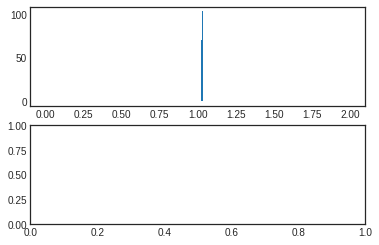

In [16]:
# fit agri-rural data with sum of exponentials
# Define the rates to use
lower = 0.
upper = 2
resolution = 350

# fit model
model, psi, rts = fit_sumexp(rural_dist, lower, upper, resolution, geom=False)


# get the activated rates
active_p = np.where(psi > 0.001)
active_rts = rts[active_p]
active_psi = psi[active_p]

print("Bounds: {} - {}\nResolution: {}\n---\n{}\nMLE: {}".format(lower,
                                                                 upper,
                                                                 resolution,
                                                                 model.message,
                                                                 -model.fun,))

print("\n#####\n")

# Get histogram data
fig, ax = plt.subplots(2, 1, sharex=False, sharey=False)


values, bins, _ = ax[0].hist(rts,
                             bins=resolution,
                             weights=psi,
                             density=True)


# show area of activated bins as weights for rates
areas = np.diff(bins)*values
area_t = sum(areas)
rte_idx = np.where(areas > 0.001)

print(bins[rte_idx], areas[rte_idx], sum(areas[rte_idx]))
print("\n")

for i in range(len(bins[rte_idx])):
    print("{} - {}".format(bins[rte_idx][i], areas[rte_idx][i]))

print("AN Pest = {}".format(1/np.mean(rural_dist)))


# get single exponential likelihood
single_exp(1/np.mean(rural_dist), rural_dist)

# create table for report
df_record = pd.DataFrame({"Location" : ["Agri-rural"]*len(bins[rte_idx]), "$\lambda$" : bins[rte_idx], "$\psi$" : areas[rte_idx]})

Text(0.04, 0.68, 'B')

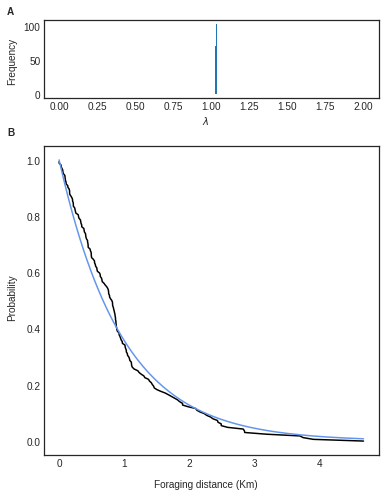

In [17]:
# Make plots # CHANGE SAVE NAME WHEN CHANGING DATA SOURCE!
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, gridspec_kw={'height_ratios': [2, 8],
                                                                      'hspace' : 0.25},
                      figsize=(6, 8))

# top - scale spectrum
values, bins, _ = ax[0].hist(rts,
                             bins=resolution,
                             weights=psi,
                             density=True)

# Bottom - cdf plot
df2 = predict(rural_dist, [psi, rts], sumexp_cdf_all)
l1 = ax[1].plot(df2["SortedData"],
              df2["Probability"],
              label = "Distance",
              linewidth=1.5,
              color="black")
l2 = ax[1].plot(df2["Lengths"],
              df2["Prediction"],
              linewidth=1.5,
              color="cornflowerblue")

# add text
fig.text(0.5, 0.07, 'Foraging distance (Km)', ha='center')
fig.text(0.5, 0.7, '$\lambda$', ha='center')
fig.text(0.04, 0.4, 'Probability', va='center', rotation='vertical')
fig.text(0.04, 0.81, 'Frequency', va='center', rotation='vertical')
fig.text(0.04, 0.89, 'A', fontweight='bold')
fig.text(0.04, 0.68, 'B', fontweight='bold')


# Save the full figure
#save_path = "../Results/Plots/Sumexp_rural_trun.pdf"
#fig.savefig(save_path)

Bounds: 0.0 - 2
Resolution: 350
---
Positive directional derivative for linesearch
MLE: -89.7474705313062

#####

[1.44       1.44571429 1.45142857 1.45714286 1.46285714 1.46857143] [0.08077192 0.20813624 0.26496565 0.25230631 0.17118926 0.02263062] 0.9999999999902653


1.44 - 0.0807719186019816
1.4457142857142857 - 0.20813624384097462
1.4514285714285715 - 0.2649656487971916
1.457142857142857 - 0.25230631096232453
1.4628571428571429 - 0.17118926220208883
1.4685714285714286 - 0.022630615585704193
AN Pest = 1.4575517242584468


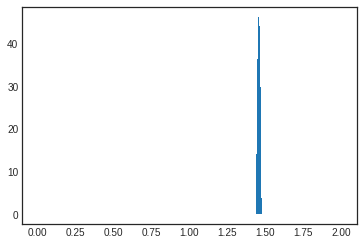

In [18]:
# fit agri-rural data with sum of exponentials
# Define the rates to use
lower = 0.
upper = 2
resolution = 350

# fit model
model, psi, rts = fit_sumexp(urban_dist, lower, upper, resolution, geom=False)


# get the activated rates
active_p = np.where(psi > 0.001)
active_rts = rts[active_p]
active_psi = psi[active_p]

print("Bounds: {} - {}\nResolution: {}\n---\n{}\nMLE: {}".format(lower,
                                                                 upper,
                                                                 resolution,
                                                                 model.message,
                                                                 -model.fun,))

print("\n#####\n")

values, bins, _ = plt.hist(rts,
                             bins=resolution,
                             weights=psi,
                             density=True)


# show area of activated bins as weights for rates
areas = np.diff(bins)*values
area_t = sum(areas)
rte_idx = np.where(areas > 0.001)

print(bins[rte_idx], areas[rte_idx], sum(areas[rte_idx]))
print("\n")

for i in range(len(bins[rte_idx])):
    print("{} - {}".format(bins[rte_idx][i], areas[rte_idx][i]))

print("AN Pest = {}".format(1/np.mean(urban_dist)))


# get single exponential likelihood
single_exp(1/np.mean(urban_dist), urban_dist)

# create table for report
df_record2 = pd.DataFrame({"Location" : ["Urban"]*len(bins[rte_idx]), "$\lambda$" : bins[rte_idx], "$\psi$" : areas[rte_idx]})

Text(0.04, 0.68, 'B')

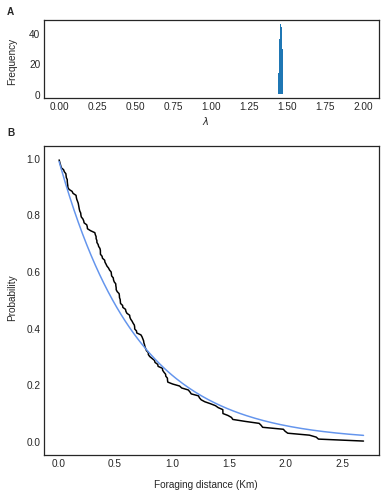

In [19]:
# Make plots # CHANGE SAVE NAME WHEN CHANGING DATA SOURCE!
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, gridspec_kw={'height_ratios': [2, 8],
                                                                      'hspace' : 0.25},
                      figsize=(6, 8))

# top - scale spectrum
values, bins, _ = ax[0].hist(rts,
                             bins=resolution,
                             weights=psi,
                             density=True)

# Bottom - cdf plot
df2 = predict(urban_dist, [psi, rts], sumexp_cdf_all)
l1 = ax[1].plot(df2["SortedData"],
              df2["Probability"],
              label = "Distance",
              linewidth=1.5,
              color="black")
l2 = ax[1].plot(df2["Lengths"],
              df2["Prediction"],
              linewidth=1.5,
              color="cornflowerblue")

# add text
fig.text(0.5, 0.07, 'Foraging distance (Km)', ha='center')
fig.text(0.5, 0.7, '$\lambda$', ha='center')
fig.text(0.04, 0.4, 'Probability', va='center', rotation='vertical')
fig.text(0.04, 0.81, 'Frequency', va='center', rotation='vertical')
fig.text(0.04, 0.89, 'A', fontweight='bold')
fig.text(0.04, 0.68, 'B', fontweight='bold')


# Save the full figure
#save_path = "../Results/Plots/Sumexp_urban_trun.pdf"
#fig.savefig(save_path)

In [20]:
# make AIC and likelihood table for urban data
s_exp_ll = single_exp(1/np.mean(urban_dist), urban_dist)
s_exp_aic = aic_eq(s_exp_ll, [1])
sumexp_loglike = -model.fun
sumexp_aic = aic_eq(sumexp_loglike, active_psi)

aic_df = pd.DataFrame({"Model" : ["Exp", "SumExp"],
                       "MLE" : [s_exp_ll, sumexp_loglike],
                       "AIC" : [s_exp_aic, sumexp_aic]})

# calulcate weighted AIC
aic_df["AIC"] = aic_df["AIC"].astype("float")
aic_df["Realtive_AICw"] = np.exp(-0.5*(aic_df["AIC"] - min(aic_df["AIC"])))
aic_df["AICw"] = aic_df["Realtive_AICw"]/sum(aic_df["Realtive_AICw"])

aic_df.drop(["Realtive_AICw"], axis=1, inplace=True)

# save table
# save table
path = "../Results/LatexTables/Sumexp_Trundata_AIC.tex"
#with open(path, 'w') as tf:
#     tf.write(aic_df.to_latex(index=False, escape=False))

aic_df

,Model,MLE,AIC,AICw
0,Exp,-89.746830,181.493659,0.993311
1,SumExp,-89.747471,191.494941,0.006689


Bounds: 0.0 - 5
Resolution: 350
---
Optimization terminated successfully.
MLE: -124.33433755750727

#####

[1.28571429 1.3        1.31428571 1.32857143 1.34285714 1.35714286
 1.37142857 1.38571429 1.4        1.41428571 1.42857143 2.04285714
 2.05714286 2.07142857 2.08571429 2.1        2.11428571 2.12857143] [0.00821088 0.06788485 0.10687453 0.12808556 0.13415152 0.12745239
 0.1101341  0.087323   0.06345401 0.04769906 0.02442481 0.00648863
 0.0146586  0.01957616 0.02098578 0.01863622 0.0122807  0.00167708] 0.999997885633254


1.2857142857142856 - 0.00821088414601961
1.3 - 0.06788485213759805
1.3142857142857143 - 0.10687453201692
1.3285714285714285 - 0.12808555634065605
1.3428571428571427 - 0.1341515159626027
1.3571428571428572 - 0.12745238877742424
1.3714285714285714 - 0.11013409575638974
1.3857142857142857 - 0.08732299706687399
1.4 - 0.06345401444304861
1.4142857142857141 - 0.04769905804595858
1.4285714285714286 - 0.02442481241726526
2.0428571428571427 - 0.006488630268232934
2.05714285

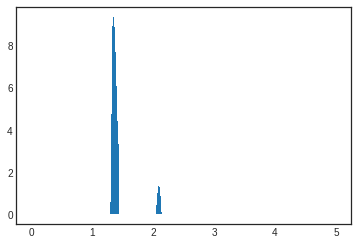

In [30]:
# combined data
# Define the rates to use
lower = 0.
upper = 5
resolution = 350

# fit model
model, psi, rts = fit_sumexp(all_dist, lower, upper, resolution, geom=False)


# get the activated rates
active_p = np.where(psi > 0.001)
active_rts = rts[active_p]
active_psi = psi[active_p]

print("Bounds: {} - {}\nResolution: {}\n---\n{}\nMLE: {}".format(lower,
                                                                 upper,
                                                                 resolution,
                                                                 model.message,
                                                                 -model.fun,))

print("\n#####\n")

values, bins, _ = plt.hist(rts,
                             bins=resolution,
                             weights=psi,
                             density=True)


# show area of activated bins as weights for rates
areas = np.diff(bins)*values
area_t = sum(areas)
rte_idx = np.where(areas > 0.001)

print(bins[rte_idx], areas[rte_idx], sum(areas[rte_idx]))
print("\n")

for i in range(len(bins[rte_idx])):
    print("{} - {}".format(bins[rte_idx][i], areas[rte_idx][i]))

print("AN Pest = {}".format(1/np.mean(all_dist)))


# get single exponential likelihood
single_exp(1/np.mean(all_dist), all_dist)

# create table for report
df_record3 = pd.DataFrame({"Location" : ["Combined"]*len(bins[rte_idx]), "$\lambda$" : bins[rte_idx], "$\psi$" : areas[rte_idx]})

Text(0.04, 0.68, 'B')

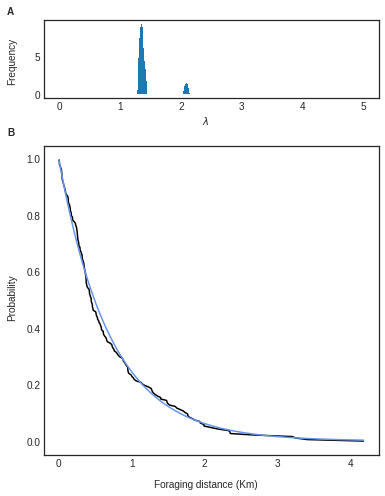

In [31]:
# Make plots # CHANGE SAVE NAME WHEN CHANGING DATA SOURCE!
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, gridspec_kw={'height_ratios': [2, 8],
                                                                      'hspace' : 0.25},
                      figsize=(6, 8))

# top - scale spectrum
values, bins, _ = ax[0].hist(rts,
                             bins=resolution,
                             weights=psi,
                             density=True)

# Bottom - cdf plot
df2 = predict(all_dist, [psi, rts], sumexp_cdf_all)
l1 = ax[1].plot(df2["SortedData"],
              df2["Probability"],
              label = "Distance",
              linewidth=1.5,
              color="black")
l2 = ax[1].plot(df2["Lengths"],
              df2["Prediction"],
              linewidth=1.5,
              color="cornflowerblue")

# add text
fig.text(0.5, 0.07, 'Foraging distance (Km)', ha='center')
fig.text(0.5, 0.7, '$\lambda$', ha='center')
fig.text(0.04, 0.4, 'Probability', va='center', rotation='vertical')
fig.text(0.04, 0.81, 'Frequency', va='center', rotation='vertical')
fig.text(0.04, 0.89, 'A', fontweight='bold')
fig.text(0.04, 0.68, 'B', fontweight='bold')


# Save the full figure
#save_path = "../Results/Plots/Sumexp_comb_trun.pdf"
#fig.savefig(save_path)

In [10]:
# get table [Manual edditing may be required later for best look formating]
df_record["Analytical $\lambda$"] = 1/np.mean(rural_dist)
df_record2["Analytical $\lambda$"] = 1/np.mean(urban_dist)
df_record3["Analytical $\lambda$"] = 1/np.mean(all_dist)
all_df = df_record.append(df_record2)
all_df = all_df.append(df_record3)

# save table
path = "../Results/LatexTables/Sumexp_Trundata.tex"
#with open(path, 'w') as tf:
#     tf.write(all_df.to_latex(index=False, escape=False))
        
all_df

,Location,$\lambda$,$\psi$,Analytical $\lambda$
0,Agri-rural,1.108571,0.003458,1.174006
1,Agri-rural,1.114286,0.013008,1.174006
2,Agri-rural,1.120000,0.021571,1.174006
3,Agri-rural,1.125714,0.029170,1.174006
4,Agri-rural,1.131429,0.035828,1.174006
5,Agri-rural,1.137143,0.041568,1.174006
6,Agri-rural,1.142857,0.046412,1.174006
7,Agri-rural,1.148571,0.050383,1.174006
8,Agri-rural,1.154286,0.053500,1.174006
9,Agri-rural,1.160000,0.055786,1.174006


In [54]:
# make AIC and likelihood table for urban data
s_exp_ll = single_exp(1/np.mean(all_dist), all_dist)
s_exp_aic = aic_eq(s_exp_ll, [1])
sumexp_loglike = -model.fun
sumexp_aic = aic_eq(sumexp_loglike, active_psi)

aic_df = pd.DataFrame({"Model" : ["Exp", "SumExp"],
                       "MLE" : [s_exp_ll, sumexp_loglike],
                       "AIC" : [s_exp_aic, sumexp_aic]})

# calulcate weighted AIC
aic_df["AIC"] = aic_df["AIC"].astype("float")
aic_df["Realtive_AICw"] = np.exp(-0.5*(aic_df["AIC"] - min(aic_df["AIC"])))
aic_df["AICw"] = aic_df["Realtive_AICw"]/sum(aic_df["Realtive_AICw"])

aic_df.drop(["Realtive_AICw"], axis=1, inplace=True)

# save table
# save table
path = "../Results/LatexTables/Sumexp_Trundata_AIC_comb.tex"
#with open(path, 'w') as tf:
#     tf.write(aic_df.to_latex(index=False, escape=False))

aic_df

,Model,MLE,AIC,AICw
0,Exp,-124.346527,250.693054,1.000000e+00
1,SumExp,-124.334338,284.668675,4.190710e-08


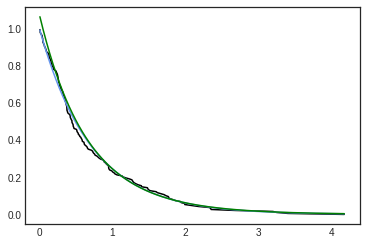

0.4308510638297872

In [23]:
# Bottom - cdf plot

def sumexp_cdf_all(psi, lamb, x):
    # combined sumexp - rates fixed in global variable
    eq_vector = np.zeros((len(lamb), len(x)))
    for i in range(len(psi)):
        eq_vector[i] = sumexp_cdfeq_single(psi[i], lamb[i], x)
    eq_vector[-1] = sumexp_single(1-sum(psi), lamb[-1], x)
    return sum(eq_vector)


df2 = predict(all_dist, [psi, rts], sumexp_cdf_all)

rts2 = [1.86, 1.17]
psi2 = [0.57]

df3 = predict(all_dist, [psi2, rts2], sumexp_cdf_all)


l1 = plt.plot(df2["SortedData"],
              df2["Probability"],
              label = "Distance",
              linewidth=1.5,
              color="black")
l2 = plt.plot(df2["Lengths"],
              df2["Prediction"],
              linewidth=1.5,
              color="cornflowerblue")
l3 = plt.plot(df3["Lengths"],
              df3["Prediction"],
              linewidth=1.5,
              color="green")

plt.show()


81/(107+81)